In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

def import_res(modelname):
    filename = f"results\\RES_{modelname}.csv"
    return pd.read_csv(filename)


def import_consts(negative_prices=False):
    prices_B = pd.read_csv("./data/balance_dw.csv")['Generation / - Imbalance price [EUR/MWh] - MBA|DK2'].to_numpy()
    prices_S = pd.read_csv("./data/balance_up.csv")['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'].to_numpy()
    prices_F = pd.read_csv("./data/forward.csv")["Price for consumption [EUR/MWh] - MBA|DK2"].to_numpy()
    if not negative_prices:
        prices_B = np.maximum(prices_B, 0)
        prices_S = np.maximum(prices_S, 0)
        prices_F = np.maximum(prices_F, 0)
    # forecast = pd.read_csv("./data/forecasts.csv")["Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK2"].to_numpy()
    realized = pd.read_csv("./data/realized.csv")["Wind Offshore  - Actual Aggregated [MW]"].to_numpy()
    features = pd.read_csv("./data/features.csv").iloc[:, 1:].to_numpy()
    max_elec = 10
    max_wind = 13
    nominal_wind = 10
    qForecast = np.array([0.7770338357162985, 0.03580588292933596, 0.016086189924938307, -0.0074103664477346435, -1.5136952354991787e-5])
    qIntercept = -0.2673501276620584
    forecast = np.dot(features, qForecast)* max_wind + qIntercept
    price_H = 35.199999999999996
    max_value = np.maximum(np.max(realized), np.max(forecast))
    # forecast /= max_value
    realized = realized/max_value*nominal_wind
    return prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind

In [3]:
def get_hydro(d, lh, ls, lb, max_elec):
    if (ls > lh):
        return 0
    elif (lb < lh):
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))
            

def get_single(qF, idx):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
    if (prices_F[idx] > price_H):
        forward_bid = qF[0]*forecast[idx] + qF[1]
    else:
        forward_bid = 0

    d = realized[idx] - forward_bid
    h_prod = get_hydro(d, price_H, prices_S[idx], prices_B[idx], max_elec)
    traded = realized[idx] - forward_bid - h_prod

    bought = np.maximum(-traded, 0)
    sold = np.maximum(traded, 0)
    obj = forward_bid * prices_F[idx] + price_H*h_prod + sold*prices_S[idx] - bought*prices_B[idx]
    return {
        "forward_bid": forward_bid,
        "d": d,
        "h_prod": h_prod,
        "bought": bought,
        "sold": sold,
        "obj": obj
    }

def run_dataset(qF, idx_start, idx_end):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()

    assert idx_end <= len(prices_F), "imported data does not contain the provided indices"
    assert len(qF) == 2, "qF must have two parameters"

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []

    for i in range(idx_start, idx_end):
        if (prices_F[i] > price_H):
            forward_bid = qF[0]*forecast[i] + qF[1]
        else:
            forward_bid = 0

        d = realized[i] - forward_bid
        h_prod = get_hydro(d, price_H, prices_S[i], prices_B[i], max_elec)
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = forward_bid * prices_F[i] + price_H*h_prod + sold*prices_S[i] - bought*prices_B[i]
        
        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        objs.append(obj)
        

    results = {
            "forward_bid": forward_bids,
            "d": ds,
            "h_prod": h_prods,
            "bought": boughts,
            "sold": solds,
            "obj": objs
        }
    return results

def run_dataset_changing_qs(qFs, idx_start, idx_end):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()

    assert idx_end <= len(prices_F), "imported data does not contain the provided indices"
    assert len(qFs[0]) == 2, "qF must have two parameters"

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    q = 0

    for i in range(idx_start, idx_end):
        
        if (prices_F[i] > price_H):
            forward_bid = qFs[q][0]*forecast[i] + qFs[q][1]
        else:
            forward_bid = 0

        if (i % 24 == 0):
            q += 1

        # print(f"Next q: {q}, and current i: {i}")
        d = realized[i] - forward_bid
        h_prod = get_hydro(d, price_H, prices_S[i], prices_B[i], max_elec)
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = forward_bid * prices_F[i] + price_H*h_prod + sold*prices_S[i] - bought*prices_B[i]
        
        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        objs.append(obj)
        

    results = {
            "forward_bid": forward_bids,
            "d": ds,
            "h_prod": h_prods,
            "bought": boughts,
            "sold": solds,
            "obj": objs
        }
    return results

In [4]:
qF_first_month = [1.0017624671856318,  0.24602104380582232] 
qF_two_months = [0.9713946781806105,  0.2562219070558971]
qF_six_months = [0.995893362204333,  0.291215525570048]
qF_one_year = [1.015227551664361,  0.29686915914042383]

res_one_month = run_dataset(qF_first_month, 0, 8760)
res_two_months = run_dataset(qF_two_months, 0, 8760)
res_six_months = run_dataset(qF_six_months, 0, 8760)
res_one_year = run_dataset(qF_one_year, 0, 8760)

print(np.sum(res_one_month["obj"]))
print(np.sum(res_two_months["obj"]))
print(np.sum(res_six_months["obj"]))
print(np.sum(res_one_year["obj"]))


1563748.9743597906
1563374.9346933367
1563731.1162554265
1563782.215643884


### Compare electrolyzer-aware optimization versus wind-optimization followed by electrolyzer policy

In [6]:
# Both models trained on first 11 months of data and then tested on last month with fixed q-values
# 0.9599708185127336, 0.28071118560958574 # Wind first
# 1.0067878135539772, 0.29440124152718783 # Electrolyzer-aware
res_wind_only = run_dataset([0.9599708185127336, 0.28071118560958574], 8760-730, 8760)
res_elec_aware = run_dataset([1.0017624671856318,  0.24602104380582232], 8760-730, 8760)

print(np.sum(res_wind_only["obj"]))
print(np.sum(res_elec_aware["obj"]))
print((np.sum(res_elec_aware["obj"]) - np.sum(res_wind_only["obj"]))/np.sum(res_elec_aware["obj"])*100)

133814.34580242558
133908.53674646153
0.07033976049957394


In [17]:
# Both models trained on first 11 months of data and then tested on last month with changing q-values
# # Wind first
# # Electrolyzer-aware

df_qs_w = pd.read_csv("results/validation_results_03_w.csv")
df_q1s_w = df_qs_w[df_qs_w.reset_index().index % 2 == 0]  # Selects every 2nd row starting from 0
df_q2s_w = df_qs_w[df_qs_w.reset_index().index % 2 != 0]  # Excludes every 2nd row starting from 0

qFs_w = [[df_q1s_w["Eleven month window"].to_numpy()[i], df_q2s_w["Eleven month window"].to_numpy()[i]] for i in range(len(df_q1s_w["Eleven month window"]))]

df_qs_e = pd.read_csv("results/validation_results_03_e.csv")
df_q1s_e = df_qs_e[df_qs_e.reset_index().index % 2 == 0]  # Selects every 2nd row starting from 0
df_q2s_e = df_qs_e[df_qs_e.reset_index().index % 2 != 0]  # Excludes every 2nd row starting from 0

qFs_e = [[df_q1s_e["Eleven month window"].to_numpy()[i], df_q2s_e["Eleven month window"].to_numpy()[i]] for i in range(len(df_q1s_e["Eleven month window"]))]

res_w = run_dataset_changing_qs(qFs_w, 8760-700, 8760)
res_e = run_dataset_changing_qs(qFs_e, 8760-700, 8760)

print(np.sum(res_w["obj"]))
print(np.sum(res_e["obj"]))
print("% difference: ", (np.sum(res_e["obj"]) - np.sum(res_w["obj"]))/np.sum(res_e["obj"])*100)

125141.14590075938
125268.6036537787
% difference:  0.10174756427523678


## Compare different training periods 

#### 4-b

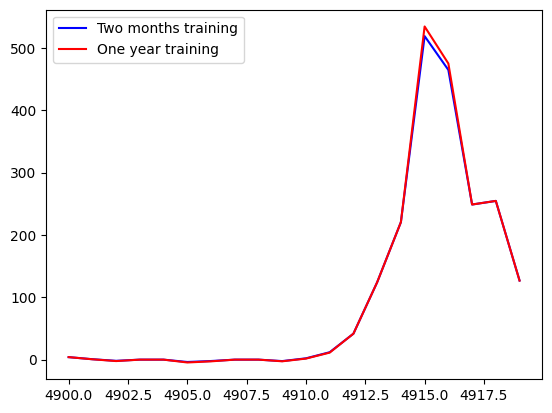

In [72]:
#-------------------PLOT OBJECTIVE VALUES
f = plt.figure()
startpoint = 4900
endpoint = startpoint + 20
xs = range(startpoint, endpoint)
plt.plot(xs, res_two_months["obj"][startpoint:endpoint], 'b', label="Two months training")
plt.plot(xs, res_one_year["obj"][startpoint:endpoint], 'r', label="One year training")
plt.legend()
plt.show()

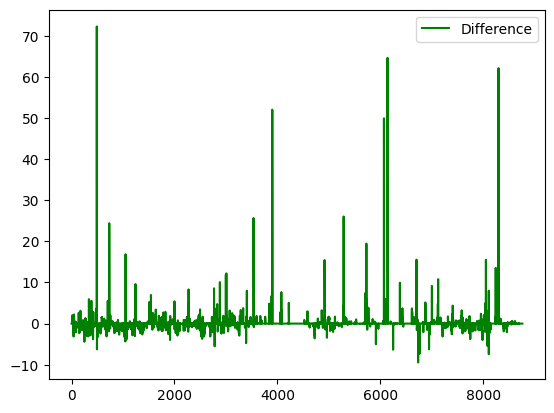

In [52]:
#-------------------PLOT OF DIFFERENCE IN OBJECTIVE VALUE
f = plt.figure()
xs = range(0, 8760)
diff = np.array(res_one_year["obj"]) - np.array(res_two_months["obj"])
plt.plot(xs, diff, 'g', label="Difference")
plt.legend()
plt.show()

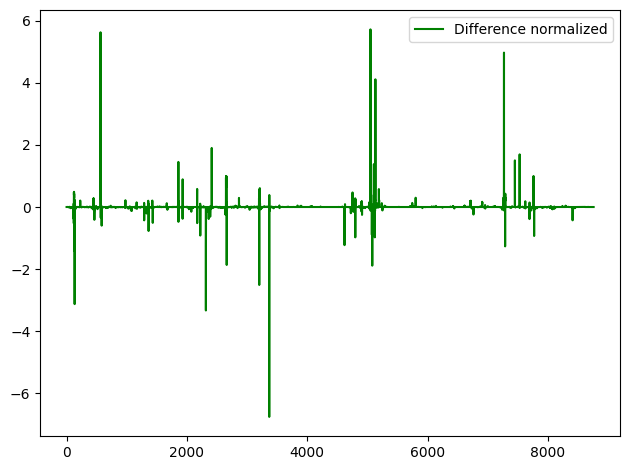

In [67]:
#-------------------PLOT OF DIFFERENCE IN OBJECTIVE VALUE NORMALIZED BY OBJECTIVE VALUE
f = plt.figure()
xs = range(0, 8760)
diffnorm = (np.array(res_one_year["obj"]) - np.array(res_two_months["obj"])) / (np.array(res_one_year["obj"]) + 0.0000001)
plt.plot(xs, diffnorm, 'g', label="Difference normalized")
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
diffnorm = (np.array(res_one_year["obj"]) - np.array(res_two_months["obj"])) / (np.array(res_one_year["obj"]) + 0.0000001)
np.max(diffnorm)

5.727365158517157

In [9]:
#---------------Import results to investigate further
prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
df_04b4 = import_res("04.b4")
df_04b1 = import_res("04.b1")
df_04b2 = import_res("04.b2")
df_04b4.columns

Index(['Forward price', 'Forward bid', 'Power sold', 'Power bought',
       'hydrogen produced', 'Objective values', 'lambda_DW', 'lambda_UP',
       'E_real', 'E_forecast'],
      dtype='object')

In [11]:
# Find index of maximum difference in objective function
df_diff = pd.DataFrame(diff)
df_diff.idxmax() # 491

df_diffnorm = pd.DataFrame(diff)
df_diffnorm.idxmax() # 491

print("forward price: ", prices_F[491])
print("buying price: ", prices_B[491])
print("selling price: ", prices_S[491])
print("hydrogen year: ", df_04b4['hydrogen produced'][491], ", hydrogen month: ", df_04b1['hydrogen produced'][491])
print("bought year: ", df_04b4['Power bought'][491], ", bought month: ", df_04b1['Power bought'][491])
print("sold bid year: ", df_04b4['Power sold'][491], ", sold month: ", df_04b1['Power sold'][491])
print("forward bid year: ", df_04b4['Forward bid'][491], ", forward bid month: ", df_04b1['Forward bid'][491])
print("Realization: ", realized[491])

forward price:  260.0
buying price:  260.0
selling price:  75.0
hydrogen year:  0.0 , hydrogen month:  0.0
bought year:  0.0 , bought month:  0.0
sold bid year:  0.3788788200420221 , sold month:  0.5372124886735747
forward bid year:  8.400962028764344 , forward bid month:  8.242628360132791
Realization:  8.779840848806366


Turns out the source of difference is that the 1y model got a little more production sold in the forward market for 260, and since the selling price was only 75 this caused a large penalty 

In [96]:
for i in diff_idx_list:
    if (i < 1050):
        print(i)

490
491
733
734
1049


In [12]:


# Check all places where difference > 5
diff_idx_list = df_diff[df_diff > 5].dropna().index.to_list()
for i in diff_idx_list:
    print("\n")
    print("i is: ", i)
    if (res_one_year['sold'][i] <  res_one_month['sold'][i]) and (prices_S[i] < prices_F[i]) and (realized[i] > res_one_year['forward_bid'][i]):
        print("Yearly bid more in forward and selling was penalized hard") 
        # 490, 491, 733, 734, 1049, 2998, 3535, 3536, 3537, 3900, 3901, 4915, 4916, 5286, 5728, 6139, 6140, 6702, 7122, 8050, 8240, 8293, 8295
        continue
    
    pen_buy = prices_B[i] - prices_F[i]
    pen_sell = prices_F[i] - prices_S[i]
    print(f"imbalance penalty is something like: {pen_sell} for selling, {pen_buy} for buying")
    # Penalty for selling even though it wasn't perfect like above
    # 1050

    # Realized overproduction, bid a little higher in forward market at a good price (higher than hydrogen) - remaining production was put in electrolyzer because low selling price
    # 3886

    print("forward price: ", prices_F[i], ", buying price: ", prices_B[i], ", selling price: ", prices_S[i])
    print("hydrogen year: ", res_one_year['h_prod'][i], ", hydrogen month: ", res_one_month['h_prod'][i])
    print("bought year: ", res_one_year['bought'][i], ", bought month: ", res_one_month['bought'][i])
    print("sold bid year: ", res_one_year['sold'][i], ", sold month: ", res_one_month['sold'][i])
    print("forward bid year: ", res_one_year['forward_bid'][i], ", forward bid month: ", res_one_month['forward_bid'][i])
    print("Realization: ", realized[i])



i is:  338
Yearly bid more in forward and selling was penalized hard


i is:  386
imbalance penalty is something like: 15.259999999999998 for selling, 0.0 for buying
forward price:  51.8 , buying price:  51.8 , selling price:  36.54
hydrogen year:  0 , hydrogen month:  0
bought year:  0.08912418831474156 , bought month:  0.0
sold bid year:  0.0 , sold month:  0.08843351502645547
forward bid year:  9.850397397863814 , forward bid month:  9.672839694522617
Realization:  9.761273209549072


i is:  490
Yearly bid more in forward and selling was penalized hard


i is:  491
Yearly bid more in forward and selling was penalized hard


i is:  704
Yearly bid more in forward and selling was penalized hard


i is:  733
Yearly bid more in forward and selling was penalized hard


i is:  734
Yearly bid more in forward and selling was penalized hard


i is:  1049
Yearly bid more in forward and selling was penalized hard


i is:  1050
imbalance penalty is something like: 42.46 for selling, 0.0 for bu

In [74]:
#----------------------CHECKING IF HYDROGEN OPERATION IS OPTIMAL
# If nothing is printed, operation is optimal
def check_hydrogen_optimality():
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, max_wind = import_consts()
    for i in range(df_04b4.shape[0]):
        if (np.abs(res_one_year["obj"][i] - df_04b4['Objective values'][i]) > 0.0001):
            print(f"objective not the same at index {i}")
            if (prices_F[i] > price_H):
                forward_bid = qF_one_year[0]*forecast[i] + qF_one_year[1]
            else:
                forward_bid = 0

            d = realized[i] - forward_bid
            h_prod = get_hydro(d, price_H, prices_S[i], prices_B[i], max_elec)
            traded = realized[i] - forward_bid - h_prod

            bought = np.maximum(-traded, 0)
            sold = np.maximum(traded, 0)
            obj = forward_bid * prices_F[i] + price_H*h_prod + sold*prices_S[i] - bought*prices_B[i]

            print(f"res_one_year['obj]: {res_one_year['obj'][i]}, julia: {df_04b4['Objective values'][i]}, difference: {np.abs(res_one_year['obj'][i] - df_04b4['Objective values'][i])}")
            print(f"Hydrogen price: ", price_H)
            print(f"forward_bid calc: {forward_bid}, forward_bid df: {df_04b4['Forward bid'][i]}")
            print(f"reazlied calc: {realized[i]}, realized df: {df_04b4['E_real'][i]}")
            print(f"bought calc: {bought}, bought df: {df_04b4['Power bought'][i]}")
            print(f"sold calc: {sold}, sold df: {df_04b4['Power sold'][i]}")
            print(f"hydrogen calc: {h_prod}, hydrogen df: {df_04b4['hydrogen produced'][i]}")
            print(f"forward price calc: {prices_F[i]}, forward price df: {df_04b4['Forward price'][i]}")
            print(f"buying price calc: {prices_B[i]}, buying price df: {df_04b4['lambda_DW'][i]}")
            print(f"selling price calc: {prices_S[i]}, selling price df: {df_04b4['lambda_UP'][i]}")
            break
check_hydrogen_optimality()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

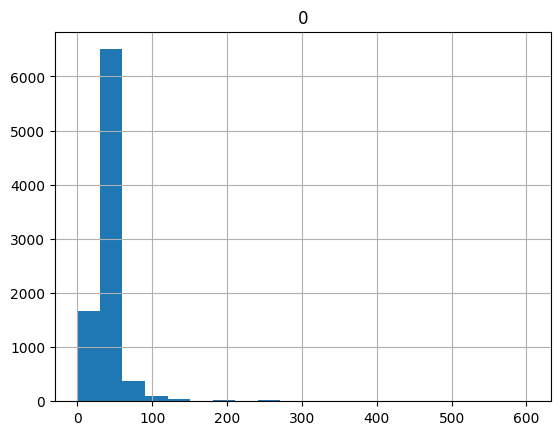

In [75]:
# ------------------FORWARD PRICE HISTOGRAM
df_fp = pd.DataFrame(prices_F)
df_fp.hist(bins=20)

In [76]:


# Assign data into price bins and return indices
def get_price_bin_indices(nbins=20):
    prices = np.array(prices_F)
    bins = np.linspace(0, prices_F.max(), nbins+1)
    ind = np.digitize(prices, bins)
    return ind, bins


# Assign objective value for each price bin 
# we do this to check where the revenue is generated - mostly whether all the revenue is generated at large prices or at low prices.
def obj_bins(obj_vals, ind, idx_end=0):
    bins = [0]*21
    if idx_end == 0:
        range_val = len(obj_vals)
    else:
        range_val = idx_end
    for i in range(range_val):
        for j in range(21):
            if (ind[i] == j+1):
                bins[j] += obj_vals[i]
    # print(objs)
    return np.array(bins)
    
ind, bins = get_price_bin_indices()
obj_bins_b4 = obj_bins(df_04b4['Objective values'].to_numpy(), ind)
obj_bins_b1 = obj_bins(df_04b1['Objective values'].to_numpy(), ind)
obj_bins_diff_pos = obj_bins(np.maximum(diff,0), ind)
obj_bins_diff_neg = obj_bins(np.maximum(-diff,0), ind)
bins


array([  0.   ,  30.123,  60.246,  90.369, 120.492, 150.615, 180.738,
       210.861, 240.984, 271.107, 301.23 , 331.353, 361.476, 391.599,
       421.722, 451.845, 481.968, 512.091, 542.214, 572.337, 602.46 ])

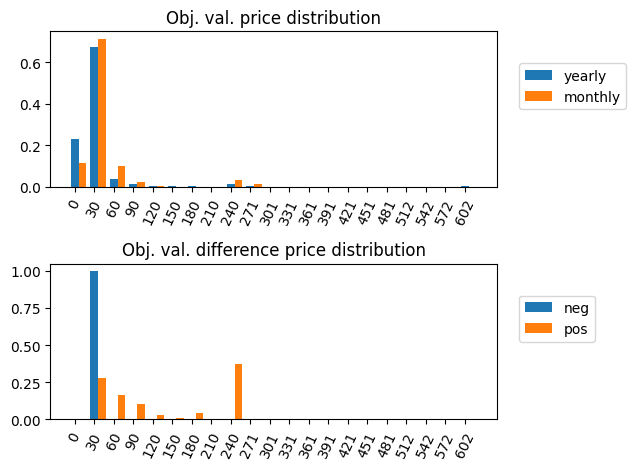

In [79]:
#-------------------plot bins
fig, ax = plt.subplots(2, 1)
w = 0.4
xs = np.array(range(21))
xticks = [int(price) for price in bins]

ax[0].bar(xs, obj_bins_b4/obj_bins_b4.sum(), w, label="yearly")
ax[0].bar(xs+w, obj_bins_b1/obj_bins_b1.sum(), w, label="monthly")
ax[0].set_title("Obj. val. price distribution")

ax[1].bar(xs, obj_bins_diff_neg/obj_bins_diff_neg.sum(), w, label="neg")
ax[1].bar(xs+w, obj_bins_diff_pos/obj_bins_diff_pos.sum(), w, label="pos")
ax[1].set_title("Obj. val. difference price distribution")

for a in ax:
    a.legend(loc=(1.05,0.5))
    a.set_xticks(xs)
    a.set_xticklabels(xticks, rotation=65)

fig.tight_layout()

#### 4-b

In [36]:
df_qs = pd.read_csv("results/validation_results_02.csv")
df_qs.head()


,One month window,Six month window,Eleven month window
0,0.990483,1.000677,1.048245
1,0.243251,0.567040,0.302501
2,0.962630,1.096600,0.960851
3,0.222403,0.295765,0.592254
4,0.963882,1.082347,0.948916


In [37]:
df_q1s = df_qs[df_qs.reset_index().index % 2 == 0]  # Selects every 2nd row starting from 0
df_q2s = df_qs[df_qs.reset_index().index % 2 != 0]  # Excludes every 2nd row starting from 0

C:\Users\emilh\AppData\Local\Temp\ipykernel_1228\3872104054.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


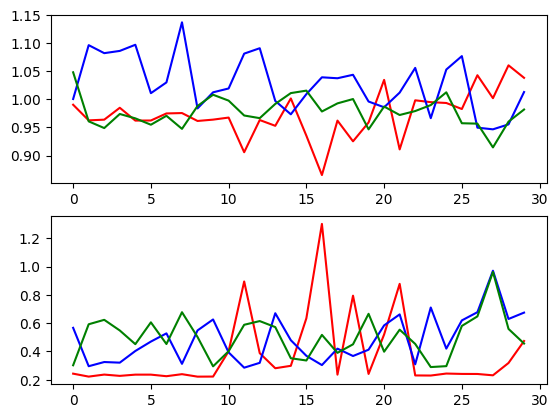

In [38]:
# 0.978414	1.012614	1.006788
f, ax = plt.subplots(2)
xs = range(len(df_q1s["One month window"]))
ax[0].plot(xs, df_q1s["One month window"], 'r')
ax[0].plot(xs, df_q1s["Six month window"], 'b')
ax[0].plot(xs, df_q1s["Eleven month window"], 'g')

ax[1].plot(xs, df_q2s["One month window"], 'r')
ax[1].plot(xs, df_q2s["Six month window"], 'b')
ax[1].plot(xs, df_q2s["Eleven month window"], 'g')

f.show()


In [45]:
qFs_1 = [[df_q1s["One month window"].to_numpy()[i], df_q2s["One month window"].to_numpy()[i]] for i in range(len(df_q1s["One month window"]))]
qFs_6 = [[df_q1s["Six month window"].to_numpy()[i], df_q2s["Six month window"].to_numpy()[i]] for i in range(len(df_q1s["One month window"]))]
qFs_11 = [[df_q1s["Eleven month window"].to_numpy()[i], df_q2s["Eleven month window"].to_numpy()[i]] for i in range(len(df_q1s["One month window"]))]

res_one_month = run_dataset_changing_qs(qFs_1, 8760-700, 8760)
res_six_month = run_dataset_changing_qs(qFs_6, 8760-700, 8760)
res_eleven_month = run_dataset_changing_qs(qFs_11, 8760-700, 8760)

In [46]:
print(np.sum(res_one_month["obj"]))
print(np.sum(res_six_month["obj"]))
print(np.sum(res_eleven_month["obj"]))

125206.97242814978
125270.75370131977
125268.6036537787


#### 4-d

In [16]:
# We want to run a model with data-driven initial hydrogen production
# and compare that with constant low hydrogen production as well as maximum last-minute production


#------------------------HYDROGEN AWARE
# qF: 0.7174301394402068,  -9.04312291694137,  56.91330230928666,  0.5193025554522224
# qH: -0.09551751608327276,  -37.7554555822627,  60.900765408475905,  5.931786201995449
df_d1 = import_res("04.d1")
df_d1["hydrogen scheduled"].max()

5.425614208902273

### 4-?

### Plots to show behavior

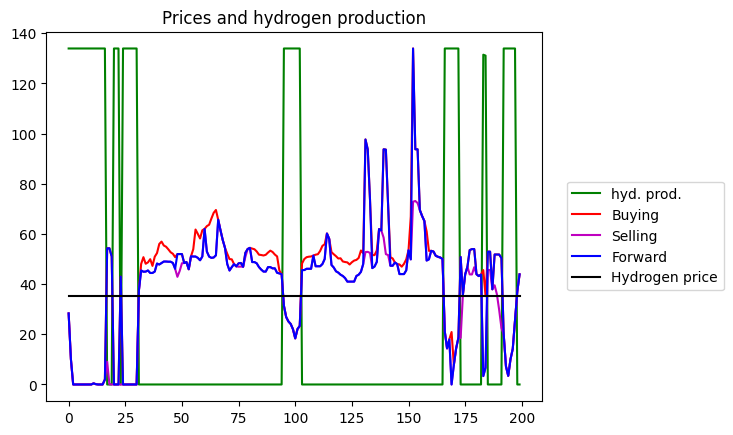

In [ ]:
def sanity_check_plot_hydrogen():

    h_price = np.ones(len(prices_F)) * price_H
    traded = df_04b4['Power bought'] - df_04b4['Power sold']
    startidx = 0
    xs = range(startidx, startidx+200)
    fig = plt.figure()
    plt.plot(xs, df_04b4['hydrogen produced'][xs]/10*prices_F[xs].max(), 'g', label="hyd. prod.")
    plt.plot(xs, prices_B[xs], 'r', label="Buying")
    plt.plot(xs, prices_S[xs], 'm', label="Selling")
    plt.plot(xs, prices_F[xs], 'b', label="Forward")
    plt.plot(xs, h_price[xs], 'k', label="Hydrogen price")

    plt.title('Prices and hydrogen production')
    plt.legend(loc=(1.05,0.3))

    plt.show()
    
sanity_check_plot_hydrogen()

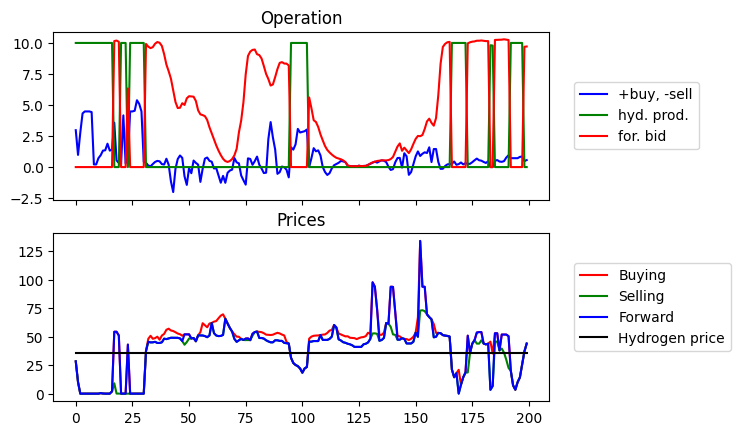

In [ ]:
def plot_operation_and_prices():

    h_price = np.ones(len(prices_F)) * price_H
    traded = df_04b4['Power bought'] - df_04b4['Power sold']
    startidx = 0
    xs = range(startidx, startidx+200)
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(xs, traded[xs], 'b', label="+buy, -sell")
    axs[0].plot(xs, df_04b4['hydrogen produced'][xs], 'g', label="hyd. prod.")
    axs[0].plot(xs, df_04b4['Forward bid'][xs], 'r', label="for. bid")
    axs[0].set_title('Operation')

    # axs[1].plot(xs, df_04b4['hydrogen produced'][xs]/10*prices_F[xs].max(), 'g', label="hyd. prod.")
    axs[1].plot(xs, prices_B[xs], 'r', label="Buying")
    axs[1].plot(xs, prices_S[xs], 'g', label="Selling")
    axs[1].plot(xs, prices_F[xs], 'b', label="Forward")
    axs[1].plot(xs, h_price[xs], 'k', label="Hydrogen price")

    axs[1].set_title('Prices')
    # axs[1, 1].plot(x, -y, 'tab:red')
    # axs[1, 1].set_title('Axis [1, 1]')
    for ax in axs.flat:
        ax.legend(loc=(1.05,0.3))
        ax.label_outer()
    plt.show()
    
plot_operation_and_prices()

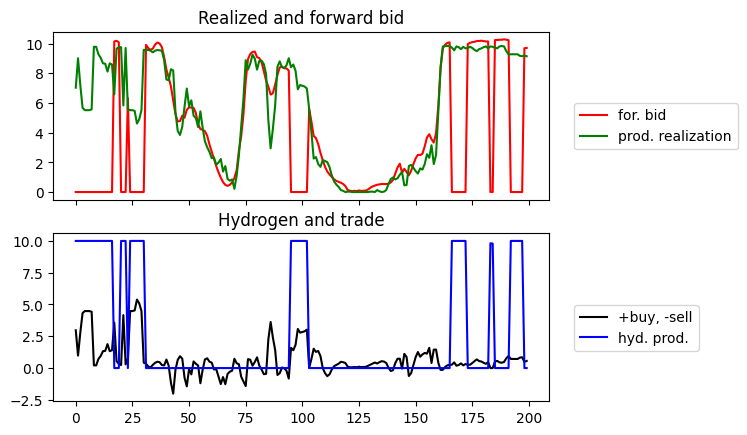

In [ ]:
def plot_forecast_and_operation():

    h_price = np.ones(len(prices_F)) * price_H
    traded = df_04b4['Power bought'] - df_04b4['Power sold']
    startidx = 0
    xs = range(startidx, startidx+200)
    fig, axs = plt.subplots(2, 1)

    
    # axs[0].plot(xs, df_04b4['E_forecast'][xs], 'b', label="prod. forecast")
    axs[0].plot(xs, df_04b4['Forward bid'][xs], 'r', label="for. bid")
    axs[0].plot(xs, df_04b4['E_real'][xs], 'g', label="prod. realization")
    axs[0].set_title('Realized and forward bid')

    # axs[1].plot(xs, df_04b4['hydrogen produced'][xs]/10*prices_F[xs].max(), 'g', label="hyd. prod.")
    axs[1].plot(xs, traded[xs], 'k', label="+buy, -sell")
    axs[1].plot(xs, df_04b4['hydrogen produced'][xs], 'b', label="hyd. prod.")

    axs[1].set_title('Hydrogen and trade')
    # axs[1, 1].plot(x, -y, 'tab:red')
    # axs[1, 1].set_title('Axis [1, 1]')
    for ax in axs.flat:
        ax.legend(loc=(1.05,0.3))
        ax.label_outer()
    plt.show()
    
plot_forecast_and_operation()